<a href="https://colab.research.google.com/github/liuxx479/cosmo_dep_feedback/blob/master/NN_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import numpy as np
from scipy import *
from pylab import *
import os
import pickle
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

In [6]:
import jax.numpy as np
from jax import jit, grad, random, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)


/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
############ colab specific 
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
home = os.path.join(root,'cosmo_dep_feedback/')
### home = '/global/homes/j/jialiu/cosmo_dep_feedback/'
###### the simulation we operate with
isim = 'IllustrisTNG'

### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)

Mounted at /content/drive


In [13]:
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')[:39]

Pk_arr = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))[:,:39]
Pk_DM_arr = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))[:,:39]

r_arr = Pk_arr/Pk_DM_arr

In [14]:
print (r_arr.shape)

(1000, 39)


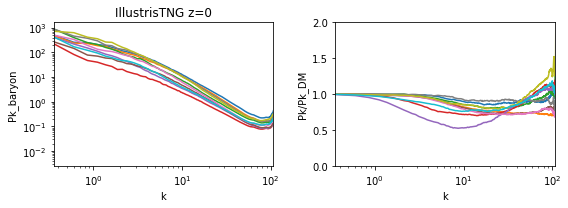

In [4]:
z=0
f, ax=subplots(1,2, figsize=(8,3))

for i in range(10):
    ax[0].plot(k, Pk_arr[i])
    ax[1].plot(k, Pk_arr[i]/Pk_DM_arr[i])
ax[0].set_xlim(k[0], k[-20])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Pk_baryon')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_ylim(0, 2)
ax[1].set_xlim(k[0], k[-20])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()

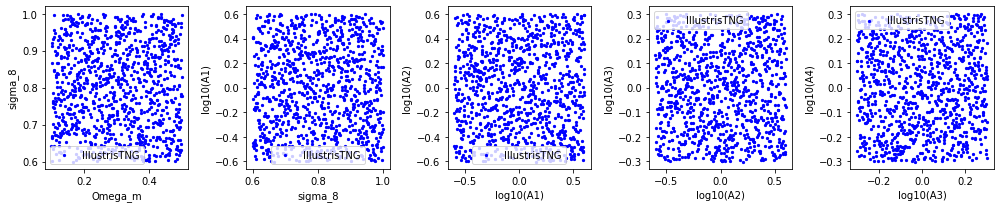

In [5]:
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_params.T[i], lhc_params.T[i+1], color='b', label=isim,s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])   
    ax[i].legend()
plt.tight_layout()
show()

In [22]:
### data loading following https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html
import tensorflow as tf
# import tensorflow_datasets as tfds
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

In [43]:
dataset = tf.data.Dataset.from_tensor_slices({'data':r_arr, 'labels':lhc_params})

In [44]:
# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100

num_labels = 6

data_size = 1000
batch_size = 64 ### number of maps per batch
valid_size = 128 
test_size = 128

train_size = data_size - valid_size - test_size

valid_batch = dataset.take(valid_size).batch(valid_size)
test_batch = dataset.skip(valid_size).take(test_size).batch(test_size)
train_batch = dataset.skip(valid_size+test_size).repeat().batch(batch_size)

In [36]:
def dense_only(nbin, num_classes):
  return stax.serial(
      Dense(nbin),
      Relu,
      Dense(256),
      Relu,
      # Dense(512)
      # Dense(256)
      Dense(128),
      Relu,
      Dense(num_classes))
  
  ### may also try keras https://www.tensorflow.org/tutorials/load_data/numpy

In [30]:
from jax import random
rng_key = random.PRNGKey(0)

In [47]:
import time
import numpy as onp

def synth_batches():
  for ibatch in train_batch:
    yield ibatch['data'].numpy(), ibatch['labels'].numpy()

batches = synth_batches()

In [48]:
itrain_batch  = next(batches)

In [52]:
itrain_batch[0].shape, itrain_batch[1].shape

((64, 39), (64, 6))

In [ ]:
for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

In [ ]:
def loss_L2(params, batch):
  kappa_map, params_true = batch
  params_pred = predict_fun(params, kappa_map)
  out2 = np.mean((params_pred - params_true)**2)
  return out2